In [1]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# Hands-on Activity 14.1: Probabilistic interpretation of least squares - Estimating the measurement noise

## Objectives

+ To demonstrate the correspondence between maximum likelihood and least squares

## Running example

Let's reuse our synthetic dataset:
$$
y_i = -0.5 + 2 x_i + + 2 x_i^2 + 0.1\epsilon_i,
$$
where $\epsilon_i \sim N(0,1)$ and where we sample $x_i \sim U([0,1])$.
Here is how to generate this synthetic dataset and how it looks like:

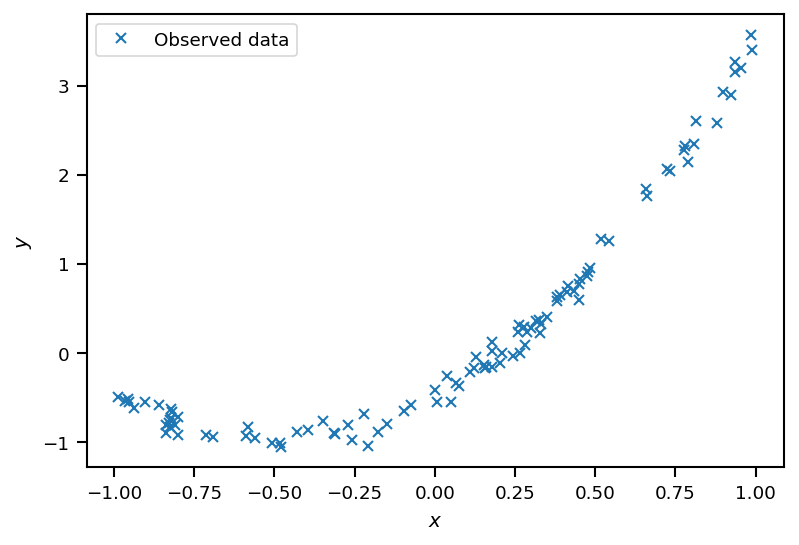

In [8]:
# How many observations we have
num_obs = 100
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = w0_true + w1_true * x + w2_true * x ** 2 + sigma_true * np.random.randn(num_obs)
# Let's plot the data
fig, ax = plt.subplots(dpi=150)
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

We will be fitting polynomials, so let's copy-paste the code we developed for computing the design matrix:

In [9]:
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

In the lecture, we saw that when least squares are interpreted probabilistically the weight estimate does not change.
So, we can obtain it just like before:

In [25]:
# The degree of the polynomial
degree = 1
# The design matrix
Phi = get_polynomial_design_matrix(x[:, None], degree)
# Solve the least squares problem
w, sum_res, _, _ = np.linalg.lstsq(Phi, y, rcond=None)

Notice that we have now also stored the second output of ``numpy.linalg.lstsq``. This is the sum of the residuals, i.e., it is:
$$
\sum_{i=1}^N\left[y_i - \sum_{j=1}^mw_j\phi_j(x_i)\right]^2 = \parallel \mathbf{y} - \mathbf{\Phi}\mathbf{w}\parallel_2^2.
$$
Let's test this just to be sure...

In [26]:
print('sum_res = {0:1.4f}'.format(sum_res[0]))
print('compare to = {0:1.4f}'.format(np.linalg.norm(y-np.dot(Phi, w)) ** 2))

sum_res = 41.0709
compare to = 41.0709


It looks correct. In the video, we saw that the sum of residuals gives us the maximum likelihood estimate of the noise variance through this formula:
$$
\sigma^2_{\text{MLE}} = \frac{\parallel \mathbf{y} - \mathbf{\Phi}\mathbf{w}\parallel_2^2}{N}.
$$
Let's compute it:

In [27]:
sigma2_MLE = sum_res[0] / num_obs
sigma_MLE = np.sqrt(sigma2_MLE)
print('True sigma = {0:1.4f}'.format(sigma_true))
print('MLE sigma = {0:1.4f}'.format(sigma_MLE))

True sigma = 0.1000
MLE sigma = 0.6409


Let's also visualize this noise.
The prediction at each $x$ is Gaussian with mean $\mathbf{w}^T\boldsymbol{\phi}(x)$ and variance $\sigma_{\text{MLE}}^2$.
So, we can simply create a 95% credible interval by subtracting and adding (about) two $\sigma_{\text{MLE}}$ to the mean.

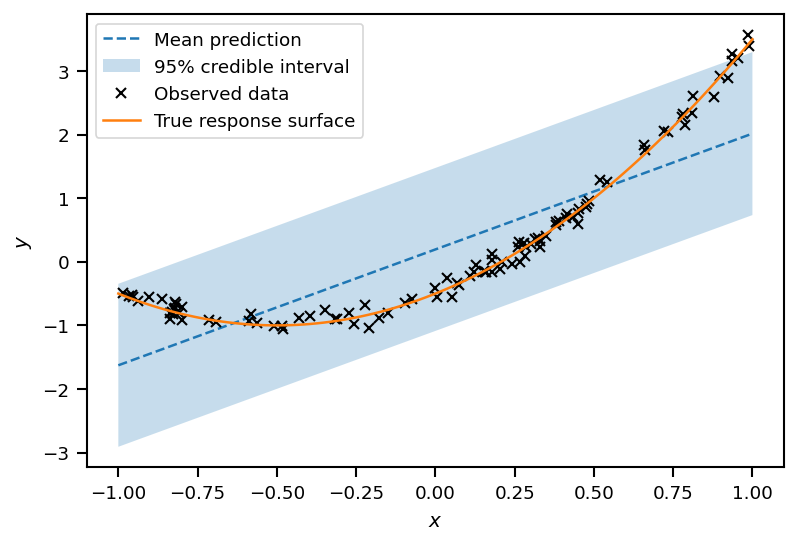

In [28]:
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# The mean prediction of the model we just fitted
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy = np.dot(Phi_xx, w)
# Lower bound for 95% credible interval
sigma_MLE = np.sqrt(sigma2_MLE)
yy_l = yy - 2.0 * sigma_MLE
# Upper bound for 95% credible interval
yy_u = yy + 2.0 * sigma_MLE
# plot mean prediction
ax.plot(xx, yy, '--', label='Mean prediction')
# plot shaded area for 95% credible interval
ax.fill_between(xx, yy_l, yy_u, alpha=0.25, label='95% credible interval')
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

## Questions

+ Increase the number of observations ``num_obs`` and notice that the likelihood noise converges to the true measurement noise.
+ Change the polynomial degree to one so that you just fit a line. What does the model think about the noise now?